In [1]:
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)

In [2]:
data = pd.read_excel('F-F_Research_Data_Factors.xls')
data['Date'] = pd.to_datetime(data['MonthYr'],format="%Y%m")
ddata = pd.read_csv("F-F_Research_Data_Factors_daily.CSV")
ddata['Date'] = pd.to_datetime(ddata['Unnamed: 0'],format="%Y%m%d")
data['Mkt-RF'] = data['Mkt-RF']/100
ddata['Mkt-RF'] = ddata['Mkt-RF']/100
data['RF'] = data['RF']/100
ddata['RF'] = ddata['RF']/100

data = data[(data.Date>='2013-01-01')&(data.Date<='2022-08-31')]
ddata = ddata[(ddata.Date>='2013-01-01')&(ddata.Date<='2022-08-31')]

In [3]:
def data_result(data,monthly=True):
    data.reset_index(drop=True,inplace=True)

    mean_mktRF = data['Mkt-RF'].mean()
    std_mktRF = data['Mkt-RF'].std()
    skew_mktRF = data['Mkt-RF'].skew()
    kurt_mktRF = data['Mkt-RF'].kurtosis()
    sharpe_ratio = mean_mktRF/std_mktRF

    res = pd.DataFrame(data={'Mean': [mean_mktRF],'Standard Deviation': [std_mktRF], 'Skewness': [skew_mktRF], 'Excess Kurtosis': [kurt_mktRF], 'Sharpe Ratio': [sharpe_ratio]})
    if monthly:
        ann_mean_mktRF = mean_mktRF*12
        ann_std_mktRF = std_mktRF*(12**0.5)
    else:
        ann_mean_mktRF = mean_mktRF*252
        ann_std_mktRF = std_mktRF*(252**0.5)

    res['Annualized Mean'] = [ann_mean_mktRF]
    res['Annualized Standard Deviation'] = [ann_std_mktRF]
    return res

In [4]:
res_monthly = data_result(data)
res_monthly

,Mean,Standard Deviation,Skewness,Excess Kurtosis,Sharpe Ratio,Annualized Mean,Annualized Standard Deviation
0,0.01072,0.042911,-0.408385,1.461224,0.249818,0.128638,0.148647


In [5]:
res_daily = data_result(ddata,False)
res_daily

,Mean,Standard Deviation,Skewness,Excess Kurtosis,Sharpe Ratio,Annualized Mean,Annualized Standard Deviation
0,0.000528,0.011153,-0.7078,15.228841,0.047345,0.133071,0.177055


0.008620689655172414

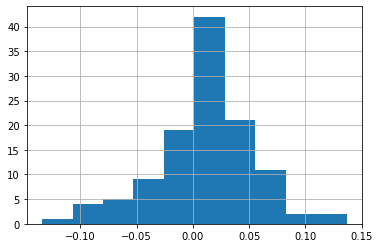

In [6]:
data['Mkt-RF'].hist()
len(data[data['Mkt-RF']<(res_monthly.loc[0,'Mean']-3*res_monthly.loc[0,'Standard Deviation'])])/len(data)

0.011503697617091208

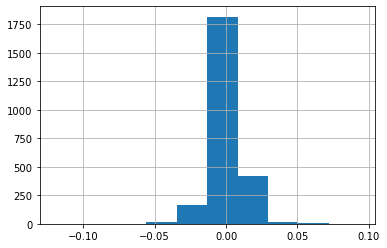

In [7]:
ddata['Mkt-RF'].hist()
len(ddata[ddata['Mkt-RF']<(res_daily.loc[0,'Mean']-3*res_daily.loc[0,'Standard Deviation'])])/len(ddata)

In [8]:
data['Month'] = data.Date.apply(lambda d: d.month)
ddata['Month'] = ddata.Date.apply(lambda d: d.month)
ddata['Mkt'] = ddata['Mkt-RF']+ddata['RF']

In [9]:
def invest(i,P=1,mkt_w=0.5,rf_w=0.5):
    mkt_rf,rf = ddata.loc[i,'Mkt'],ddata.loc[i,'RF']
    if (i==0) or (ddata.loc[i-1,'Month'] != ddata.loc[i,'Month']):
        if i>0: P = ddata.loc[i-1,'Amt_RF']+ddata.loc[i-1,'Amt_Mkt']
        ddata.loc[i,'Amt_RF'] = P*rf_w*(1+rf)
        ddata.loc[i,'Amt_Mkt'] = P*mkt_w*(1+mkt_rf)
    else:
        ddata.loc[i,'Amt_RF'] = ddata.loc[i-1,'Amt_RF']*(1+rf)
        ddata.loc[i,'Amt_Mkt'] = ddata.loc[i-1,'Amt_Mkt']*(1+mkt_rf)

In [10]:
ddata['Amt_RF'] = 0
ddata['Amt_Mkt'] = 0
ddata

,Unnamed: 0,Mkt-RF,SMB,HML,RF,Date,Month,Mkt,Amt_RF,Amt_Mkt
0,20130102,0.0262,0.14,0.38,0.00000,2013-01-02,1,0.02620,0,0
1,20130103,-0.0014,0.11,0.04,0.00000,2013-01-03,1,-0.00140,0,0
2,20130104,0.0055,0.12,0.36,0.00000,2013-01-04,1,0.00550,0,0
3,20130107,-0.0031,-0.10,-0.35,0.00000,2013-01-07,1,-0.00310,0,0
4,20130108,-0.0027,0.05,0.00,0.00000,2013-01-08,1,-0.00270,0,0
...,...,...,...,...,...,...,...,...,...,...
2429,20220825,0.0145,0.18,-0.01,0.00008,2022-08-25,8,0.01458,0,0
2430,20220826,-0.0337,-0.55,1.69,0.00008,2022-08-26,8,-0.03362,0,0
2431,20220829,-0.0072,-0.56,0.42,0.00008,2022-08-29,8,-0.00712,0,0
2432,20220830,-0.0111,-0.25,-0.24,0.00008,2022-08-30,8,-0.01102,0,0


In [11]:
ddata.apply(lambda row: invest(row.name),axis=1)

ddata['Total_Amt'] = ddata['Amt_Mkt']+ddata['Amt_RF']
ddata['Total_Return'] = (ddata['Mkt']+ddata['RF'])/2

sharpe_ratio = (ddata['Total_Return']-ddata['RF']).mean()*(252**0.5)/(ddata['Total_Return']-ddata['RF']).std()
sharpe_ratio

0.7515816050824181

In [12]:
ddata['Cum_Return'] = (1+ddata['Total_Return']).cumprod()
ddata['Return_Peaks'] = ddata['Cum_Return'].cummax()
ddata['Drawdown'] = 1-ddata['Cum_Return']/ddata['Return_Peaks']
ddata['Max_Drawdown'] = ddata['Drawdown'].cummax()
ddata

,Unnamed: 0,Mkt-RF,SMB,HML,RF,Date,Month,Mkt,Amt_RF,Amt_Mkt,Total_Amt,Total_Return,Cum_Return,Return_Peaks,Drawdown,Max_Drawdown
0,20130102,0.0262,0.14,0.38,0.00000,2013-01-02,1,0.02620,0.500000,0.513100,1.013100,0.01310,1.013100,1.013100,0.000000,0.000000
1,20130103,-0.0014,0.11,0.04,0.00000,2013-01-03,1,-0.00140,0.500000,0.512382,1.012382,-0.00070,1.012391,1.013100,0.000700,0.000700
2,20130104,0.0055,0.12,0.36,0.00000,2013-01-04,1,0.00550,0.500000,0.515200,1.015200,0.00275,1.015175,1.015175,0.000000,0.000700
3,20130107,-0.0031,-0.10,-0.35,0.00000,2013-01-07,1,-0.00310,0.500000,0.513603,1.013603,-0.00155,1.013601,1.015175,0.001550,0.001550
4,20130108,-0.0027,0.05,0.00,0.00000,2013-01-08,1,-0.00270,0.500000,0.512216,1.012216,-0.00135,1.012233,1.015175,0.002898,0.002898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,20220825,0.0145,0.18,-0.01,0.00008,2022-08-25,8,0.01458,0.977339,0.998560,1.975898,0.00733,1.996424,2.128563,0.062079,0.182089
2430,20220826,-0.0337,-0.55,1.69,0.00008,2022-08-26,8,-0.03362,0.977417,0.964988,1.942405,-0.01677,1.962944,2.128563,0.077808,0.182089
2431,20220829,-0.0072,-0.56,0.42,0.00008,2022-08-29,8,-0.00712,0.977495,0.958117,1.935612,-0.00352,1.956035,2.128563,0.081054,0.182089
2432,20220830,-0.0111,-0.25,-0.24,0.00008,2022-08-30,8,-0.01102,0.977573,0.947559,1.925132,-0.00547,1.945335,2.128563,0.086080,0.182089


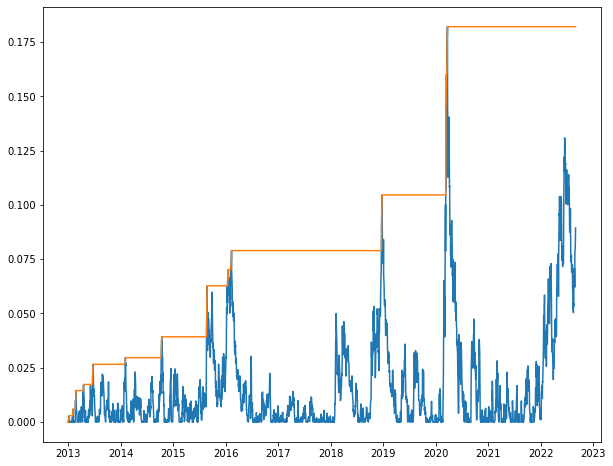

In [13]:
plt.figure(figsize=(10,8))
plt.plot(ddata['Date'],ddata[['Drawdown','Max_Drawdown']])

In [14]:
ddata.apply(lambda row: invest(row.name,mkt_w=3,rf_w=-2),axis=1)

ddata['Total_Amt'] = ddata['Amt_Mkt']+ddata['Amt_RF']
ddata['Total_Return'] = 3*ddata['Mkt']-2*ddata['RF']

sharpe_ratio = (ddata['Total_Return']-ddata['RF']).mean()*(252**0.5)/(ddata['Total_Return']-ddata['RF']).std()
sharpe_ratio

0.7515816050824174

In [15]:
ddata['Cum_Return'] = (1+ddata['Total_Return']).cumprod()
ddata['Return_Peaks'] = ddata['Cum_Return'].cummax()
ddata['Drawdown'] = 1-ddata['Cum_Return']/ddata['Return_Peaks']
ddata['Max_Drawdown'] = ddata['Drawdown'].cummax()
ddata

,Unnamed: 0,Mkt-RF,SMB,HML,RF,Date,Month,Mkt,Amt_RF,Amt_Mkt,Total_Amt,Total_Return,Cum_Return,Return_Peaks,Drawdown,Max_Drawdown
0,20130102,0.0262,0.14,0.38,0.00000,2013-01-02,1,0.02620,-2.000000,3.078600,1.078600,0.07860,1.078600,1.078600,0.000000,0.000000
1,20130103,-0.0014,0.11,0.04,0.00000,2013-01-03,1,-0.00140,-2.000000,3.074290,1.074290,-0.00420,1.074070,1.078600,0.004200,0.004200
2,20130104,0.0055,0.12,0.36,0.00000,2013-01-04,1,0.00550,-2.000000,3.091199,1.091199,0.01650,1.091792,1.091792,0.000000,0.004200
3,20130107,-0.0031,-0.10,-0.35,0.00000,2013-01-07,1,-0.00310,-2.000000,3.081616,1.081616,-0.00930,1.081638,1.091792,0.009300,0.009300
4,20130108,-0.0027,0.05,0.00,0.00000,2013-01-08,1,-0.00270,-2.000000,3.073295,1.073295,-0.00810,1.072877,1.091792,0.017325,0.017325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,20220825,0.0145,0.18,-0.01,0.00008,2022-08-25,8,0.01458,-36.163497,55.423080,19.259583,0.04358,14.874020,26.380239,0.436168,0.771580
2430,20220826,-0.0337,-0.55,1.69,0.00008,2022-08-26,8,-0.03362,-36.166390,53.559756,17.393366,-0.10102,13.371446,26.380239,0.493126,0.771580
2431,20220829,-0.0072,-0.56,0.42,0.00008,2022-08-29,8,-0.00712,-36.169283,53.178410,17.009127,-0.02152,13.083693,26.380239,0.504034,0.771580
2432,20220830,-0.0111,-0.25,-0.24,0.00008,2022-08-30,8,-0.01102,-36.172177,52.592384,16.420208,-0.03322,12.649052,26.380239,0.520510,0.771580


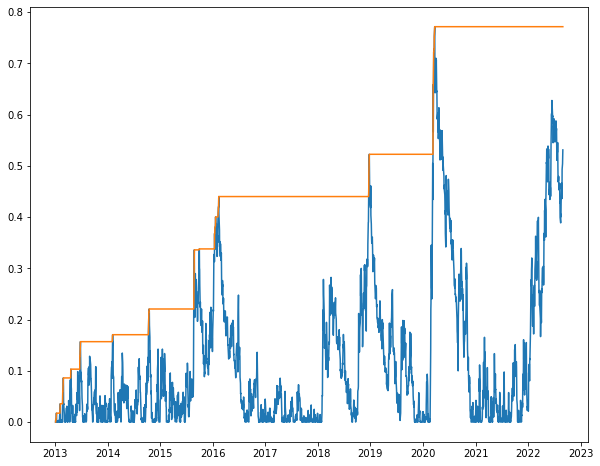

In [16]:
plt.figure(figsize=(10,8))
plt.plot(ddata['Date'],ddata[['Drawdown','Max_Drawdown']])